In [89]:
!pip install scikit-learn

In [90]:
!pip install tensorflow

In [91]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

Note: you may need to restart the kernel to use updated packages.


라벨에 따라 이미지를 분리하는 코드

In [113]:
import os
import numpy as np
import cv2
import shutil

path = "./img/raw"
directorys = os.listdir(path)
directorys.sort()

labels = ["LEFT", "RIGHT", "BOTH", "LLR", "LRR", "Four"]
image_paths = [[] for i in labels]

for directory in directorys:
	label = directory.split("_")[1]

	directory_path = "%s/%s"%(path,directory)

	for file in os.listdir(directory_path):
	
		file_path = "%s/%s"%(directory_path, file)
		image_paths[labels.index(label)].append(file_path)

		#img = cv2.imread(file_path,0)
		#if not (img.shape==(24,8)): 
			#img = cv2.resize(img, dsize=(8,24))
			#cv2.imwrite(file_path, img)

for label in labels:
	print("%s : %s"%(label, len(image_paths[labels.index(label)] )))

#print(image_paths)

LEFT : 711
RIGHT : 702
BOTH : 706
LLR : 202
LRR : 208
Four : 605


In [114]:
for label in labels:
	if os.path.isdir("./img/IMG_SET/%s"%(label)):
		print("CHECK DIRECTORY IS EMPTY!")
	else:
		os.mkdir("./img/IMG_SET/%s"%(label))

	num = 0
	for file_train in image_paths[labels.index(label)]:
		shutil.copyfile(file_train, "./img/IMG_SET/%s/%04d.png"%(label, num))
		num+=1


In [112]:
from sklearn.model_selection import train_test_split


train_set = [[] for i in labels]
test_set = [[] for i in labels]

for label in labels:

	train_set[labels.index(label)], test_set[labels.index(label)], = train_test_split(
		image_paths[labels.index(label)],
		test_size=0.3,
		shuffle=True
	)
	print(label, len(train_set[labels.index(label)]), len(test_set[labels.index(label)]))


LEFT 497 214
RIGHT 491 211
BOTH 494 212
LLR 141 61
LRR 145 63
Four 423 182


저장

In [64]:
if not os.path.isdir("./img/Train"):
	os.mkdir("./img/Train")
	os.mkdir("./img/Test")

for label in labels:
	if os.path.isdir("./img/Train/%s"%(label)):
		print("CHECK DIRECTORY IS EMPTY!")
	else:
		os.mkdir("./img/Train/%s"%(label))
		os.mkdir("./img/Test/%s"%(label))

	num = 0
	for file_train in train_set[labels.index(label)]:
		shutil.copyfile(file_train, "./img/Train/%s/%04d.png"%(label, num))
		num+=1

	num = 0
	for file_train in test_set[labels.index(label)]:
		shutil.copyfile(file_train, "./img/Test/%s/%04d.png"%(label, num))
		num+=1


In [61]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [115]:
batch_size = 32
img_height = 24
img_width = 8

In [116]:
data_dir = "img/IMG_SET"
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  color_mode="grayscale",
  batch_size=batch_size)

Found 3134 files belonging to 6 classes.
Using 2508 files for training.


In [117]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  color_mode="grayscale",
  batch_size=batch_size)


Found 3134 files belonging to 6 classes.
Using 626 files for validation.


In [118]:
class_names = train_ds.class_names
print(class_names)


['BOTH', 'Four', 'LEFT', 'LLR', 'LRR', 'RIGHT']


In [123]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 24, 8, 1)
(32,)


In [124]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [125]:
normalization_layer = layers.Rescaling(1./255)


In [126]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


0.0 1.0


In [127]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 1)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])


/home/leecurrent04/.local/share/anaconda3/envs/ML/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [128]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [129]:
model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)         │ (None, 24, 8, 1)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 24, 8, 16)      │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 12, 4, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 12, 4, 32)      │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 6, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 6, 2, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 3, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,774 (190.52 KB)

 Trainable params: 48,774 (190.52 KB)

 Non-trainable params: 0 (0.00 B)

In [130]:
epochs=30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3684 - loss: 1.5210 - val_accuracy: 0.5447 - val_loss: 1.0243
Epoch 2/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5780 - loss: 0.9334 - val_accuracy: 0.6629 - val_loss: 0.7680
Epoch 3/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6487 - loss: 0.7708 - val_accuracy: 0.6997 - val_loss: 0.7027
Epoch 4/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6868 - loss: 0.7144 - val_accuracy: 0.6869 - val_loss: 0.6713
Epoch 5/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6823 - loss: 0.6723 - val_accuracy: 0.6486 - val_loss: 0.6926
Epoch 6/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7094 - loss: 0.6288 - val_accuracy: 0.6933 - val_loss: 0.6440
Epoch 7/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7386 - loss: 0.5728 - val_accuracy: 0.7173 - val_loss: 0.6185
Epoch 8/30
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7587 - loss: 0.5324 - val_accuracy: 0.7332 - val_loss:

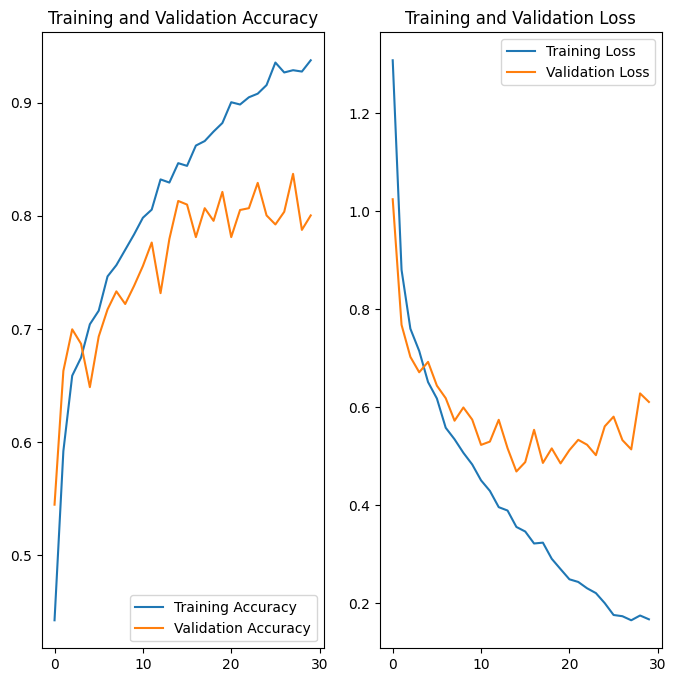

In [131]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [132]:
model.save("img/my_model.keras")

In [133]:
new_model = tf.keras.models.load_model("img/my_model.keras")
new_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)         │ (None, 24, 8, 1)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 24, 8, 16)      │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 12, 4, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 12, 4, 32)      │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 6, 2, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 6, 2, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 3, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 146,324 (571.58 KB)

 Trainable params: 48,774 (190.52 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 97,550 (381.06 KB)

In [ ]:

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
